# Different approaches to add curved noise to an image in Python

In [75]:
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import make_interp_spline
import random
import math

In [76]:
# drawing random lines
def random_coords(width, height):
    return int(random.random() * width), int(random.random() * height)

def draw_random_lines(numLines, image, dims):
    for _ in range(numLines):
        x0, y0 = random_coords(dims[0], dims[1])
        x1, y1 = random_coords(dims[0], dims[1])
        image[draw.line(x0, y0, x1, y1)] = 255
    
    return image

In [77]:
# noisy sinusoids approach

def draw_sinusoid_noise(num_noise, image, dims, segment_length=5):
    for _ in range(num_noise):
        x = np.linspace(0, 1, num=10)
        y = np.random.uniform(-0.2, 1.2, size=(10,)) + 0.2 * np.sin(5 * np.pi * x)
        spline = make_interp_spline(x, y, k=5)
        xx = np.linspace(0, 1, num=dims[1])
        yy = np.clip(spline(xx), 0, dims[0])
        xx *= dims[1]
        yy *= dims[0]
        for i in range(len(xx) - 1):
            start = (int(xx[i]), int(yy[i]))
            end = (int(xx[i + 1]), int(yy[i + 1]))
            for j in range(0, int(np.ceil(np.linalg.norm(np.array(end) - np.array(start)) / segment_length))):
                t = j / np.ceil(np.linalg.norm(np.array(end) - np.array(start)) / segment_length)
                xj = int((1 - t) * start[0] + t * end[0])
                yj = int((1 - t) * start[1] + t * end[1])
                if xj >= 0 and xj < dims[1] and yj >= 0 and yj < dims[0]:
                    image[yj, xj] = 255
    return image

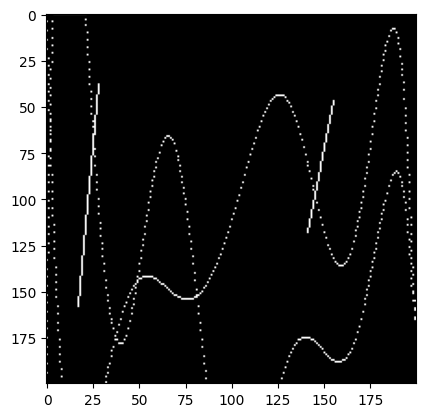

In [78]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = draw_sinusoid_noise(2, image, [200, 200])
plt.imshow(image, cmap=cm.gray)

In [79]:
# big bezier scribbles approach

def draw_bezier_noise(numNoise, image, dims, num_points=15, noise_factor=5, wiggle_factor=10, frequency=2):
    height, width = dims
    for _ in range(numNoise):
        points = [random_coords(height, width) for _ in range(num_points)]
        noisy_points = [(r + np.random.randint(-noise_factor, noise_factor),
                         c + np.random.randint(-noise_factor, noise_factor)) for r, c in points]
        wiggly_points = [(r, c + int(wiggle_factor * math.sin(frequency * i / (len(noisy_points) - 1) * math.pi))) 
                         for i, (r, c) in enumerate(noisy_points)]

        for i in range(len(wiggly_points) - 2):
            r0, c0 = wiggly_points[i]
            r1, c1 = wiggly_points[i+1]
            r2, c2 = wiggly_points[i+2]

            r0, c0 = np.clip(r0, 0, height - 1), np.clip(c0, 0, width - 1)
            r1, c1 = np.clip(r1, 0, height - 1), np.clip(c1, 0, width - 1)
            r2, c2 = np.clip(r2, 0, height - 1), np.clip(c2, 0, width - 1)

            image[draw.bezier_curve(r0, c0, r1, c1, r2, c2, 0.5)] = 255
            
    return image

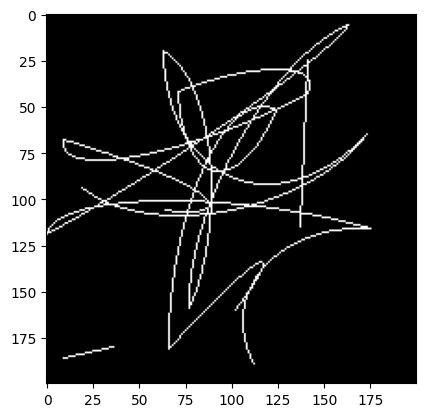

In [80]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = draw_bezier_noise(1, image, [200, 200])
plt.imshow(image, cmap=cm.gray)

In [102]:
# super noisy sinusoids approach 1

def sinusoid_noise1(numNoise, image, dims, num_points=100, amplitude=10, frequency=2, noise_factor=5):
    height, width = dims
    
    for _ in range(numNoise):
        x = np.linspace(0, width, num_points)
        y = amplitude * np.sin(frequency * 2 * np.pi * x / width) + height / 2
        noisy_x = x + np.random.randint(-noise_factor, noise_factor, size=num_points)
        noisy_y = y + np.random.randint(-noise_factor, noise_factor, size=num_points)

        noisy_x = np.clip(noisy_x, 0, width - 1).astype(int)
        noisy_y = np.clip(noisy_y, 0, height - 1).astype(int)

        for i in range(len(noisy_x) - 1):
            r0, c0 = noisy_y[i], noisy_x[i]
            r1, c1 = noisy_y[i + 1], noisy_x[i + 1]
            rr, cc = draw.line(r0, c0, r1, c1)
            image[rr, cc] = 255
            
    return image

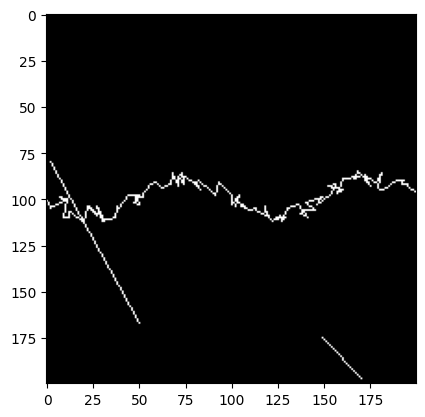

In [82]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = sinusoid_noise1(1, image, [200, 200])
plt.imshow(image, cmap=cm.gray)

# noisy lines are being overlapped

In [180]:
# super noisy sinusoids approach 2
# changing randomly sinusoid parameters for each line determined by numNoise to avoid overlap
# adding rotation so the lines can take more positions other than being horizontal

def rotate_points(x, y, angle_degrees, origin):
    angle_radians = np.deg2rad(angle_degrees)
    ox, oy = origin
    px, py = x - ox, y - oy
    qx = ox + px * np.cos(angle_radians) - py * np.sin(angle_radians)
    qy = oy + px * np.sin(angle_radians) + py * np.cos(angle_radians)
    return qx, qy

def sinusoid_noise2(numNoise, image, dims, num_points=100, amplitude_range=(5, 15), frequency_range=(1, 4), noise_factor=5, angle_range=(0, 360), line_thickness=0.5):
    height, width = dims
    
    for _ in range(numNoise):
        amplitude = np.random.randint(*amplitude_range)
        frequency = np.random.randint(*frequency_range)
        vertical_shift = np.random.randint(0, height)
        angle = np.random.randint(*angle_range)

        x = np.linspace(0, width, num_points)
        y = amplitude * np.sin(frequency * 2 * np.pi * x / width) + vertical_shift
        noisy_x = x + np.random.randint(-noise_factor, noise_factor, size=num_points)
        noisy_y = y + np.random.randint(-noise_factor, noise_factor, size=num_points)

        origin = (width // 2, height // 2)
        noisy_x, noisy_y = rotate_points(noisy_x, noisy_y, angle, origin)

        noisy_x = np.clip(noisy_x, 0, width - 1).astype(int)
        noisy_y = np.clip(noisy_y, 0, height - 1).astype(int)

        for i in range(len(noisy_x) - 1):
            r0, c0 = noisy_y[i], noisy_x[i]
            r1, c1 = noisy_y[i + 1], noisy_x[i + 1]
            
            rr, cc = draw.line(r0, c0, r1, c1)
            for r, c in zip(rr, cc):
                rr_disk, cc_disk = draw.disk((r, c), line_thickness, shape=image.shape)
                image[rr_disk, cc_disk] = 255
            
    return image

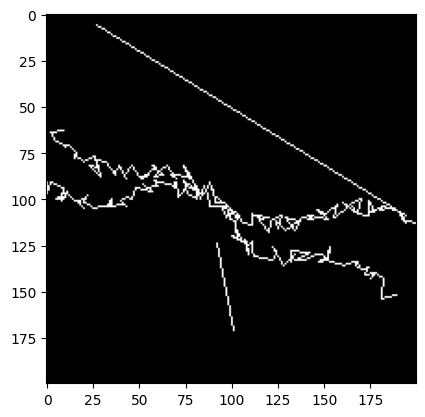

In [181]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = sinusoid_noise2(2, image, [200, 200])
plt.imshow(image, cmap=cm.gray)

In [85]:
# one could still see the sinusoid length
# combining sinusoids and bezier curves to generate small random scribbles

def random_sinusoid_bezier_noise(numNoise, image, dims, num_points=15, amplitude=10, frequency=5, noise_factor=10, scribble_length=40):
    height, width = dims
    
    for _ in range(numNoise):
        start_x = np.random.randint(0, width - scribble_length)
        start_y = np.random.randint(0, height)

        x = np.linspace(start_x, start_x + scribble_length, num_points)
        y = amplitude * np.sin(frequency * 2 * np.pi * (x - start_x) / scribble_length) + start_y
        noisy_x = x + np.random.randint(-noise_factor, noise_factor, size=num_points)
        noisy_y = y + np.random.randint(-noise_factor, noise_factor, size=num_points)

        noisy_x = np.clip(noisy_x, 0, width - 1).astype(int)
        noisy_y = np.clip(noisy_y, 0, height - 1).astype(int)
        
        for i in range(len(noisy_x) - 2):
            r0, c0 = noisy_y[i], noisy_x[i]
            r1, c1 = noisy_y[i + 1], noisy_x[i + 1]
            r2, c2 = noisy_y[i + 2], noisy_x[i + 2]
            image[draw.bezier_curve(r0, c0, r1, c1, r2, c2, 0.5)] = 255
            
    return image

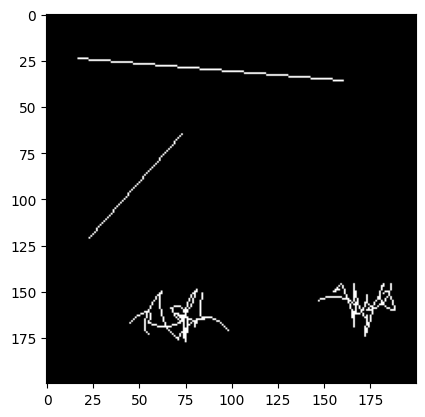

In [86]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = random_sinusoid_bezier_noise(2, image, [200, 200])
plt.imshow(image, cmap=cm.gray)

In [87]:
# random sinusoid scribbles

def sinusoid_noise3(numNoise, image, dims, num_points_range=(50, 100), amplitude_range=(5, 20), frequency_range=(8, 15), noise_factor=10, scribble_length=40):
    height, width = dims
    
    for _ in range(numNoise):
        start_x = np.random.randint(0, width - scribble_length)
        start_y = np.random.randint(0, height)

        num_points = np.random.randint(*num_points_range)
        amplitude = np.random.randint(*amplitude_range)
        frequency = np.random.randint(*frequency_range)

        x = np.linspace(start_x, start_x + scribble_length, num_points)
        y = amplitude * np.sin(frequency * 2 * np.pi * (x - start_x) / scribble_length) + start_y
        noisy_x = x + np.random.randint(-noise_factor, noise_factor, size=num_points)
        noisy_y = y + np.random.randint(-noise_factor, noise_factor, size=num_points)
        noisy_x = np.clip(noisy_x, 0, width - 1).astype(int)
        noisy_y = np.clip(noisy_y, 0, height - 1).astype(int)

        # Draw the sinusoidal line
        for i in range(len(noisy_x) - 1):
            r0, c0 = noisy_y[i], noisy_x[i]
            r1, c1 = noisy_y[i + 1], noisy_x[i + 1]
            rr, cc = draw.line(r0, c0, r1, c1)
            image[rr, cc] = 255
            
    return image


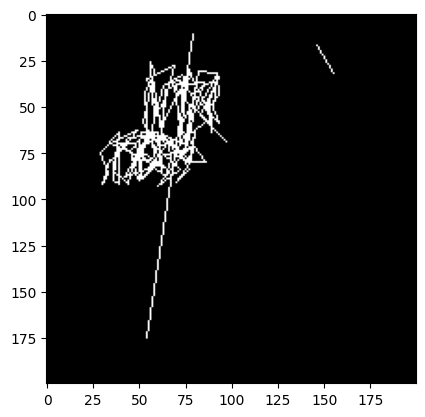

In [88]:
image = np.zeros((200, 200))
image = draw_random_lines(2, image, [200, 200])
image = sinusoid_noise3(2, image, [200, 200])
plt.imshow(image, cmap=cm.gray)